In [75]:
import pandas as pd
import re
import numpy as np
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss
import time
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [77]:
df_examples = pd.read_parquet(r'Data\shopping_queries_dataset_examples.parquet')
display(df_examples.head())

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
0,0,revent 80 cfm,0,B000MOO21W,us,I,0,1,train
1,1,revent 80 cfm,0,B07X3Y6B1V,us,E,0,1,train
2,2,revent 80 cfm,0,B07WDM7MQQ,us,E,0,1,train
3,3,revent 80 cfm,0,B07RH6Z8KW,us,E,0,1,train
4,4,revent 80 cfm,0,B07QJ7WYFQ,us,E,0,1,train


In [78]:
df_products = pd.read_parquet(r'Data\shopping_queries_dataset_products.parquet')
display(df_products.head())

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale
0,B079VKKJN7,"11 Degrees de los Hombres Playera con Logo, Ne...",Esta playera con el logo de la marca Carrier d...,11 Degrees Negro Playera con logo\nA estrenar ...,11 Degrees,Negro,es
1,B079Y9VRKS,Camiseta Eleven Degrees Core TS White (M),None,None,11 Degrees,Blanco,es
2,B07DP4LM9H,11 Degrees de los Hombres Core Pull Over Hoodi...,La sudadera con capucha Core Pull Over de 11 G...,11 Degrees Azul Core Pull Over Hoodie\nA estre...,11 Degrees,Azul,es
3,B07G37B9HP,11 Degrees Poli Panel Track Pant XL Black,None,None,11 Degrees,None,es
4,B07LCTGDHY,11 Degrees Gorra Trucker Negro OSFA (Talla úni...,None,None,11 Degrees,Negro (,es


In [79]:
df_sources = pd.read_csv(r"Data\shopping_queries_dataset_sources.csv")
display(df_sources.head(5))

,query_id,source
0,0,other
1,1,negations
2,2,negations
3,3,negations
4,4,behavioral


In [ ]:
df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

df_examples_products = df_examples_products[(df_examples_products["small_version"] == 1)
                                                 & (df_examples_products['esci_label']=='E') 
                                                 & (df_examples_products['product_locale']=='us')]

#Determine a random sample of 50 unique queries from the dataset
unique_queries = df_examples_products['query'].drop_duplicates().head(50).tolist()
print(len(unique_queries))

#Filter the dataset derived from point number 1 to contain only the unique queries
df_examples_products_filtered = df_examples_products[df_examples_products['query'].isin(unique_queries)]
print(df_examples_products_filtered.shape)

50
(579, 14)


In [ ]:
df_task1=df_examples_products_filtered
print(df_task1.shape)

# Clean up 'None' strings in the DataFrame and fill NaN values
df_task1 = df_task1.replace('None', '')
df_task1 = df_task1.fillna('')
display(df_task1.head())

(579, 14)


,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
17,17,!awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,Please check your existing tire Sidewall for t...,MaxAuto,
20,20,!awnmower tires without rims,1,B07C1WZG12,us,E,1,1,train,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...,No fuss. Just take off your old assembly and r...,Tire size:15x6.00-6 Ply: 4 Tubeless\n6x4.5 Whe...,Antego Tire & Wheel,Husqvarna Silver
21,21,!awnmower tires without rims,1,B077QMNXTS,us,E,1,1,train,MaxAuto 2 Pcs 16x6.50-8 Lawn Mower Tire for Ga...,<br>Tire Specifications:<br> 1. Material: Rubb...,"Set of 2 16X6.50-8, 16x6.50x8, 16-6.50-8 Lawn ...",MaxAuto,Black
23,23,!awnmower tires without rims,1,B06XX6BM2R,us,E,1,1,train,"MARASTAR 21446-2PK 15x6.00-6"" Front Tire Assem...",,Tire: 2 pack 15x6. 00-6 tube-type turf SAVER t...,MARASTAR,
26,26,!awnmower tires without rims,1,B0089RNSNM,us,E,1,1,train,Honda 42710-VE2-M02ZE (Replaces 42710-VE2-M01Z...,Honda 42710-VE2-M02ZE (Replaces 42710-VE2-M01Z...,Set of 2 Honda OEM Rear Wheels\nReplaces 42710...,Honda,


In [ ]:
# Save the DataFrame to a CSV file
df_task1.to_csv('df_task1.csv', index=False)

In [ ]:
############################################################################

#You can directly upload the df_task1 file here and continue

#df_task1= pd.read_csv('Data\df_task1.csv')

In [83]:
def clean_product_text(text: str) -> str:
    """
    Cleans product text by removing HTML tags, special characters,
    normalizing whitespace, and converting to lowercase.
    """
    # 1. Remove HTML tags (e.g., <br>)
    text = re.sub(r'<[^>]+>', '', text)
    
    # 2. Remove non-ASCII characters and specific problematic symbols
    # This regex keeps alphanumeric, common punctuation, and basic spaces
    text = re.sub(r'[^\x00-\x7F]+', ' ', text) # Replace non-ASCII with space
    text = text.replace('Â', '').replace('â¤', '').replace('âœ½', '') # Remove specific symbols if they persist

    # 3. Normalize whitespace: replace multiple spaces/newlines with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 4. Convert to lowercase
    text = text.lower()
    
    return text

In [85]:
# Combine relevant text columns for embedding
product_df = df_task1.rename(columns={'product_id': 'product_id_str'})
product_df['product_id'] = product_df['product_id_str']
product_df['product_text'] = product_df['product_title'] + " " + product_df['product_description'] + " " + product_df['product_bullet_point']

# Apply the cleaning function here
product_df['product_text'] = product_df.apply(
    lambda row: clean_product_text(
        row['product_title'] + " " + row['product_description'] + " " + row['product_bullet_point']
    ),
    axis=1
)

product_texts_list = product_df['product_text'].tolist()


--- Token Count Statistics (after cleaning) ---
count    579.000000
mean     215.704663
std      160.278620
min        3.000000
25%       79.000000
50%      167.000000
75%      341.500000
max      745.000000
Name: product_text, dtype: float64
----------------------------------------


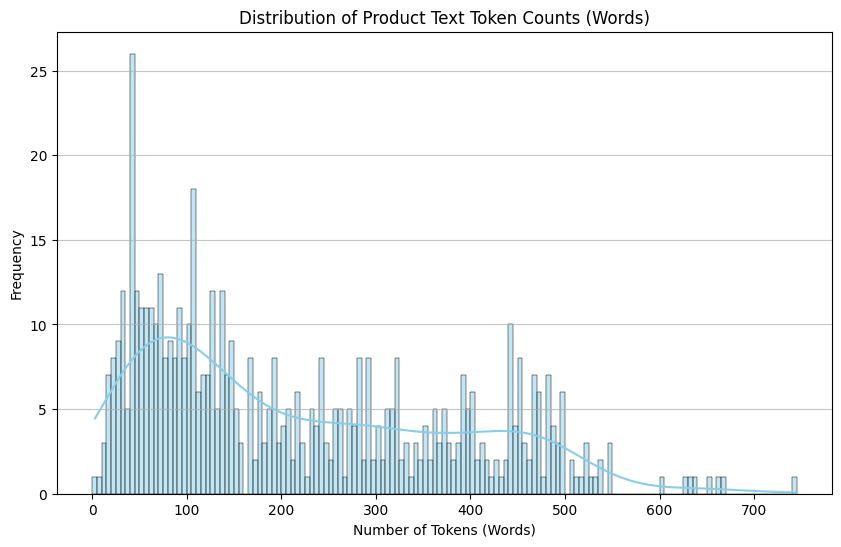

In [86]:
# Display basic statistics
print("--- Token Count Statistics (after cleaning) ---")
print(token_counts.describe())
print("-" * 40)

# --- Plotting the distribution curve ---
plt.figure(figsize=(10, 6))
sns.histplot(token_counts, bins=range(0, token_counts.max() + 5, 5), kde=True, color='skyblue')
plt.title('Distribution of Product Text Token Counts (Words)')
plt.xlabel('Number of Tokens (Words)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [98]:

# Define a set of search queries from the unique queries in the dataset
search_queries = product_df['query'].unique().tolist()

# Define the ground truth from the dataset itself
ground_truth = product_df.groupby('query')['product_id'].apply(list).to_dict()
#

In [99]:
lengths = [len(v) for v in ground_truth.values()]
max_len = max(lengths)
min_len = min(lengths)
print("Max number of product matches:", max_len)
print("Min number of product matches:", min_len)

Max number of product matches: 33
Min number of product matches: 1


In [88]:
# --- Define Models and Indices to Test ---
# Bi-encoder models for embedding
bi_encoder_models = {
    "MiniLM-L6-v2": SentenceTransformer('all-MiniLM-L6-v2'),
    "MPNet-base-v1": SentenceTransformer('multi-qa-mpnet-base-cos-v1'),
    "BGE-Small-EN-v1.5": SentenceTransformer('BAAI/bge-small-en-v1.5'),
    #"BGE-Base-EN-v1.5": SentenceTransformer('BAAI/bge-base-en-v1.5')
}

# Cross-encoder models for re-ranking
cross_encoder_models = {
    "MiniLM-L6-v2-reranker": CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2'),
    "TinyBERT-L-2-reranker": CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2'),
    #"BGE-Reranker-v2-M3": CrossEncoder('BAAI/bge-reranker-v2-m3') # Added new re-ranker model
}

In [89]:
# --- Utility Functions ---
def create_embeddings(texts: List[str], model: SentenceTransformer) -> np.ndarray:
    """Generates embeddings for a list of texts using a given bi-encoder model."""
    embeddings = model.encode(texts, convert_to_tensor=True)
    return embeddings.cpu().numpy().astype('float32')

def create_faiss_index(embeddings: np.ndarray, index_type: str) -> faiss.Index:
    """Creates and populates a FAISS index of a specified type."""
    dimension = embeddings.shape[1]
    if index_type == "FlatL2":
        # Brute-force search (exhaustive, most accurate)
        index = faiss.IndexFlatL2(dimension)
    elif index_type == "IVFFlat":
        # Approximate nearest neighbor search (faster, can be less accurate)
        nlist = 10  # Number of inverted lists
        quantizer = faiss.IndexFlatL2(dimension)
        index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
        index.train(embeddings)
    else:
        raise ValueError("Invalid index type specified.")

    index.add(embeddings)
    return index

def search_index(index: faiss.Index, query_embedding: np.ndarray, k: int) -> Tuple[List[str], List[int]]:
    """
    Searches the FAISS index for the top k similar items.
    Returns a list of original product IDs and their corresponding indices.
    """
    # For IVFFlat index, we set the number of probes
    if hasattr(index, 'nprobe'):
        index.nprobe = 5
    
    D, I = index.search(query_embedding, k)
    results_indices = I.flatten().tolist()
    results_ids = product_df.iloc[results_indices]['product_id'].tolist()
    
    return results_ids, results_indices

def rerank_results(query: str, candidates_indices: List[int], reranker_model: CrossEncoder) -> List[str]:
    """
    Re-ranks a list of candidate documents based on a cross-encoder model.
    """
    candidate_texts = [product_texts_list[i] for i in candidates_indices]
    sentence_pairs = [[query, text] for text in candidate_texts]
    scores = reranker_model.predict(sentence_pairs)
    scored_products = sorted(
        zip(scores, [product_df.iloc[i]['product_id'] for i in candidates_indices]),
        key=lambda x: x[0],
        reverse=True
    )
    return [product_id for score, product_id in scored_products]

def calculate_hits_at_n(retrieved_ids: List[str], relevant_ids: List[str], n: int) -> int:
    """Calculates if a relevant item is in the top N results."""
    retrieved_top_n = set(retrieved_ids[:n])
    relevant_set = set(relevant_ids)
    is_hit = len(retrieved_top_n.intersection(relevant_set)) > 0
    return 1 if is_hit else 0

def calculate_mrr(retrieved_ids: List[str], relevant_ids: List[str]) -> float:
    """Calculates the Mean Reciprocal Rank for a single query."""
    for rank, item_id in enumerate(retrieved_ids, 1):
        if item_id in relevant_ids:
            return 1.0 / rank
    return 0.0


In [93]:
# --- 4. Main Experimentation Loop ---
results = []
print("\nStarting comprehensive experimentation...")

# Iterate through all combinations of bi-encoders and FAISS index types
for bi_encoder_name, bi_encoder in bi_encoder_models.items():
    for index_type in ["FlatL2", "IVFFlat"]:
        print(f"\n--- Running experiments for Bi-encoder: {bi_encoder_name} and Index: {index_type} ---")
        
        # Create embeddings and index for the current bi-encoder and index type
        product_embeddings = create_embeddings(product_texts_list, bi_encoder)
        faiss_index = create_faiss_index(product_embeddings, index_type)
        
        # --- Experiment 1: Vector Search Only ---
        print("- Vector Search Only -")
        vector_search_only_metrics = {'hits@1': [], 'hits@5': [], 'hits@10': [], 'mrr': [], 'latency': []}
        for query in search_queries:
            relevant_ids = ground_truth.get(query, [])
            start_time = time.time()
            query_embedding = create_embeddings([query], bi_encoder)
            retrieved_ids, _ = search_index(faiss_index, query_embedding, k=10)
            end_time = time.time()
            vector_search_only_metrics['latency'].append(end_time - start_time)
            vector_search_only_metrics['hits@1'].append(calculate_hits_at_n(retrieved_ids, relevant_ids, n=1))
            vector_search_only_metrics['hits@5'].append(calculate_hits_at_n(retrieved_ids, relevant_ids, n=5))
            vector_search_only_metrics['hits@10'].append(calculate_hits_at_n(retrieved_ids, relevant_ids, n=10))
            vector_search_only_metrics['mrr'].append(calculate_mrr(retrieved_ids, relevant_ids))
        
        results.append({
            "Bi-encoder": bi_encoder_name,
            "Re-ranker": "None",
            "FAISS Index": index_type,
            "Avg Latency": np.mean(vector_search_only_metrics['latency']),
            "HITS@1": np.mean(vector_search_only_metrics['hits@1']),
            "HITS@5": np.mean(vector_search_only_metrics['hits@5']),
            "HITS@10": np.mean(vector_search_only_metrics['hits@10']),
            "MRR": np.mean(vector_search_only_metrics['mrr'])
        })

        # --- Experiment 2: Vector Search with Re-ranking ---
        for reranker_name, reranker in cross_encoder_models.items():
            print(f"- Vector Search + Re-ranker: {reranker_name} -")
            reranking_metrics = {'hits@1': [], 'hits@5': [], 'hits@10': [], 'mrr': [], 'latency': []}
            num_candidates_for_reranking = 40
            
            for query in search_queries:
                relevant_ids = ground_truth.get(query, [])
                start_time = time.time()
                query_embedding = create_embeddings([query], bi_encoder)
                _, candidate_indices = search_index(faiss_index, query_embedding, k=num_candidates_for_reranking)
                retrieved_ids = rerank_results(query, candidate_indices, reranker)
                end_time = time.time()
                reranking_metrics['latency'].append(end_time - start_time)
                reranking_metrics['hits@1'].append(calculate_hits_at_n(retrieved_ids, relevant_ids, n=1))
                reranking_metrics['hits@5'].append(calculate_hits_at_n(retrieved_ids, relevant_ids, n=5))
                reranking_metrics['hits@10'].append(calculate_hits_at_n(retrieved_ids, relevant_ids, n=10))
                reranking_metrics['mrr'].append(calculate_mrr(retrieved_ids, relevant_ids))
            
            results.append({
                "Bi-encoder": bi_encoder_name,
                "Re-ranker": reranker_name,
                "FAISS Index": index_type,
                "Avg Latency": np.mean(reranking_metrics['latency']),
                "HITS@1": np.mean(reranking_metrics['hits@1']),
                "HITS@5": np.mean(reranking_metrics['hits@5']),
                "HITS@10": np.mean(reranking_metrics['hits@10']),
                "MRR": np.mean(reranking_metrics['mrr'])
            })




Starting comprehensive experimentation...

--- Running experiments for Bi-encoder: MiniLM-L6-v2 and Index: FlatL2 ---
- Vector Search Only -
- Vector Search + Re-ranker: MiniLM-L6-v2-reranker -
- Vector Search + Re-ranker: TinyBERT-L-2-reranker -

--- Running experiments for Bi-encoder: MiniLM-L6-v2 and Index: IVFFlat ---
- Vector Search Only -
- Vector Search + Re-ranker: MiniLM-L6-v2-reranker -
- Vector Search + Re-ranker: TinyBERT-L-2-reranker -

--- Running experiments for Bi-encoder: MPNet-base-v1 and Index: FlatL2 ---
- Vector Search Only -
- Vector Search + Re-ranker: MiniLM-L6-v2-reranker -
- Vector Search + Re-ranker: TinyBERT-L-2-reranker -

--- Running experiments for Bi-encoder: MPNet-base-v1 and Index: IVFFlat ---
- Vector Search Only -
- Vector Search + Re-ranker: MiniLM-L6-v2-reranker -
- Vector Search + Re-ranker: TinyBERT-L-2-reranker -

--- Running experiments for Bi-encoder: BGE-Small-EN-v1.5 and Index: FlatL2 ---
- Vector Search Only -
- Vector Search + Re-ranker: 

In [97]:
# --- Print the Final Results in a Clear Format ---
print("\n" + "=" * 100)
print("COMPREHENSIVE SEARCH PERFORMANCE COMPARISON")
print("=" * 100)

results_df = pd.DataFrame(results)

# Round the numerical columns for better readability
results_df = results_df.round(4)

print(results_df.to_string())

print("\n" + "=" * 100)
print("ANALYSIS OF RESULTS:")
print("-" * 100)
print("The 'Bi-encoder' and 'FAISS Index' columns define the first retrieval step.")
print("The 'Re-ranker' column indicates if a second, more accurate, step was used.")
print("\n- Latency vs. Accuracy Trade-off:")
print("  - 'FlatL2' is a brute-force index, which is more accurate but slower.")
print("  - 'IVFFlat' is an approximate index, which is faster but may have slightly lower accuracy.")
print("  - Adding a re-ranker increases latency but can significantly improve HITS@N and MRR, as the cross-encoder is more precise at a fine-grained level.")
print("\n- Model Comparison:")
print("\n  Bi-encoder Models:")
print("  | Model Name          | Context Window (Tokens) | Embedding Size (Dimensions) |")
print("  |:--------------------|:------------------------|:----------------------------|")
print("  | MiniLM-L6-v2        | 256                     | 384                         |")
print("  | MPNet-base-v1       | 512                     | 768                         |")
print("  | BGE-Small-EN-v1.5   | 512                     | 384                         |")
print("\n  Cross-encoder Models:")
print("  | Model Name              | Context Window (Tokens) | Output                               |")
print("  |:------------------------|:------------------------|:-------------------------------------|")
print("  | MiniLM-L6-v2-reranker   | 512                     | Single relevance score (cross-encoder) |")
print("  | TinyBERT-L-2-reranker   | 512                     | Single relevance score (cross-encoder) |")
print("-" * 100)


COMPREHENSIVE SEARCH PERFORMANCE COMPARISON
           Bi-encoder              Re-ranker FAISS Index  Avg Latency  HITS@1  HITS@5  HITS@10     MRR
0        MiniLM-L6-v2                   None      FlatL2       0.0200    0.76    0.92     0.92  0.8200
1        MiniLM-L6-v2  MiniLM-L6-v2-reranker      FlatL2       6.7041    0.70    0.80     0.90  0.7555
2        MiniLM-L6-v2  TinyBERT-L-2-reranker      FlatL2       0.4240    0.72    0.84     0.88  0.7677
3        MiniLM-L6-v2                   None     IVFFlat       0.0182    0.76    0.92     0.92  0.8200
4        MiniLM-L6-v2  MiniLM-L6-v2-reranker     IVFFlat       6.8153    0.70    0.80     0.90  0.7558
5        MiniLM-L6-v2  TinyBERT-L-2-reranker     IVFFlat       0.5378    0.72    0.84     0.88  0.7684
6       MPNet-base-v1                   None      FlatL2       0.0901    0.80    0.88     0.92  0.8457
7       MPNet-base-v1  MiniLM-L6-v2-reranker      FlatL2       6.2520    0.70    0.88     0.92  0.7823
8       MPNet-base-v1  TinyB